## 1. 고객 세그먼트 정의를 위한 K-means 알고리즘 사용 (표본 5만)

In [9]:
# 환경 설정 및 임포트
import os, gc, math, random, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

try:
    from tqdm.notebook import tqdm
except Exception:
    def tqdm(x, *args, **kwargs):
        return x

# 재현성
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 경로 설정 (현재 노트북과 동일 폴더)
DATA_DIR = "."
PATH_ORDERS = os.path.join(DATA_DIR, "orders.csv")
PATH_PRIOR = os.path.join(DATA_DIR, "order_products__prior.csv")
PATH_TRAIN = os.path.join(DATA_DIR, "order_products__train.csv")
PATH_PRODUCTS = os.path.join(DATA_DIR, "products.csv")
PATH_DEPTS = os.path.join(DATA_DIR, "departments.csv")
PATH_AISLES = os.path.join(DATA_DIR, "aisles.csv")

# 결과 경로
FIG_DIR = os.path.join(DATA_DIR, "figs")
os.makedirs(FIG_DIR, exist_ok=True)

# 유틸: 메모리 다운캐스팅
def reduce_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:3] != 'dat':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type).startswith('int'):
                if c_min >= 0:
                    if c_max < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif c_max < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif c_max < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if np.iinfo(np.int8).min <= c_min and c_max <= np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif np.iinfo(np.int16).min <= c_min and c_max <= np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif np.iinfo(np.int32).min <= c_min and c_max <= np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)
            elif str(col_type).startswith('float'):
                df[col] = df[col].astype(np.float32)
    return df

# 플롯 스타일
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)
print("환경 설정 완료")


환경 설정 완료


In [10]:
# 한글/마이너스/폰트 설정 (그래프·마크다운 표시 깨짐 방지)
from matplotlib import font_manager, rcParams
from IPython.display import display, HTML

# 가능한 한글 폰트 중 시스템에 설치된 폰트를 자동 선택
CANDIDATES = ['Malgun Gothic', '맑은 고딕', 'NanumGothic', 'AppleGothic', 'D2Coding', 'Noto Sans CJK KR', 'Batang', 'Gulim', 'Dotum']

available_fonts = {f.name for f in font_manager.fontManager.ttflist}
chosen = None
for name in CANDIDATES:
    if name in available_fonts:
        chosen = name
        break

if chosen is None:
    print('경고: 한글 폰트를 찾지 못했습니다. 시스템 기본 폰트를 사용합니다.')
    chosen = rcParams.get('font.family', ['DejaVu Sans'])[0] if isinstance(rcParams.get('font.family'), list) else rcParams.get('font.family', 'DejaVu Sans')

rcParams['font.family'] = chosen
rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지
sns.set(font=chosen)

# 노트북(마크다운 포함) 표시용 CSS 주입
css = f"""
<style>
body, .rendered_html {{
  font-family: '{chosen}', 'Malgun Gothic', 'NanumGothic', 'AppleGothic', sans-serif !important;
}}
</style>
"""
display(HTML(css))
print('적용 폰트:', chosen)


적용 폰트: Malgun Gothic


In [11]:
# 1) 데이터 로드 (dtype 최적화)
ORDERS_DTYPES = {
    'order_id': np.int32,
    'user_id': np.int32,
    'eval_set': 'category',
    'order_number': np.int16,
    'order_dow': np.int8,
    'order_hour_of_day': np.int8,
    'days_since_prior_order': np.float32,
}

OP_DTYPES = {
    'order_id': np.int32,
    'product_id': np.int32,
    'add_to_cart_order': np.int16,
    'reordered': np.int8,
}

PROD_DTYPES = {
    'product_id': np.int32,
    'aisle_id': np.int16,
    'department_id': np.int8,
    'product_name': 'string',
}

DEPT_DTYPES = {'department_id': np.int8, 'department': 'string'}
AISLE_DTYPES = {'aisle_id': np.int16, 'aisle': 'string'}

# 로드
orders = pd.read_csv(PATH_ORDERS, dtype=ORDERS_DTYPES)
products = pd.read_csv(PATH_PRODUCTS, dtype=PROD_DTYPES)
prior = pd.read_csv(PATH_PRIOR, dtype=OP_DTYPES)
train = pd.read_csv(PATH_TRAIN, dtype=OP_DTYPES)

departments = pd.read_csv(PATH_DEPTS, dtype=DEPT_DTYPES)
aisles = pd.read_csv(PATH_AISLES, dtype=AISLE_DTYPES)

print(orders.shape, prior.shape, train.shape, products.shape)
orders.head(2)


(3421083, 7) (32434489, 4) (1384617, 4) (49688, 4)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0


In [13]:
# 2) user × department 비율 행렬 생성
# prior+train 모두 사용하여 사용자 선호 반영
op_all = pd.concat([prior, train], axis=0, ignore_index=True)
user_orders = orders[['order_id', 'user_id']]
op_all = op_all.merge(user_orders, on='order_id', how='left')

# product → department 조인
df_prod = products.merge(departments, on='department_id', how='left')
df_prod = df_prod[['product_id', 'department_id', 'department']]

op_all = op_all.merge(df_prod, on='product_id', how='left')

# 사용자×부서 구매 건수 피벗
user_dept_counts = (
    op_all.groupby(['user_id', 'department_id'], observed=True)
          ['product_id']
          .count()
          .rename('cnt')
          .reset_index()
)

# 부서별 비율화
total_by_user = user_dept_counts.groupby('user_id', observed=True)['cnt'].sum().rename('total')
user_dept_counts = user_dept_counts.merge(total_by_user, on='user_id', how='left')
user_dept_counts['ratio'] = (user_dept_counts['cnt'] / user_dept_counts['total']).astype(np.float32)

# 피벗: 행=user, 열=department_id, 값=ratio
user_dept_ratio = user_dept_counts.pivot(index='user_id', columns='department_id', values='ratio').fillna(0.0)

# 안정화를 위한 소량 평활화 (라플라스)
alpha = 1e-6
user_dept_ratio = (user_dept_ratio + alpha)
user_dept_ratio = user_dept_ratio.div(user_dept_ratio.sum(axis=1), axis=0)

print(user_dept_ratio.shape)
user_dept_ratio.head(3)


(206209, 21)


department_id,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
user_id,,,,,,,,,,,,,,,,,,,,,
1,9.999790e-07,9.999790e-07,9.999790e-07,0.071428,9.999790e-07,9.999790e-07,0.214282,9.999790e-07,9.999790e-07,9.999790e-07,...,9.999790e-07,0.014286,5.714266e-02,9.999790e-07,0.242853,4.285724e-02,9.999790e-07,0.357136,9.999790e-07,9.999790e-07
2,1.238922e-01,9.999790e-07,8.850372e-03,0.190262,9.999790e-07,1.327506e-02,0.039823,9.999790e-07,9.999790e-07,9.999790e-07,...,4.425686e-03,0.048673,1.327506e-02,1.769974e-02,0.216811,9.999790e-07,9.999790e-07,0.207961,1.061935e-01,9.999790e-07
3,6.818139e-02,9.999790e-07,9.999790e-07,0.431810,9.999790e-07,9.999790e-07,0.034091,9.999790e-07,4.545459e-02,9.999790e-07,...,9.999790e-07,0.045455,9.999790e-07,9.999790e-07,0.238632,1.136440e-02,9.999790e-07,0.102272,2.272780e-02,9.999790e-07


   k       sil      inertia       dbi            ch
0  2  0.230753  3684.047607  1.525362  16672.068359
1  3  0.159956  3384.634766  2.008685  11604.750000
2  4  0.148831  2998.424072  1.862296  10709.049805
3  5  0.143835  2784.520020  1.799343   9567.195312


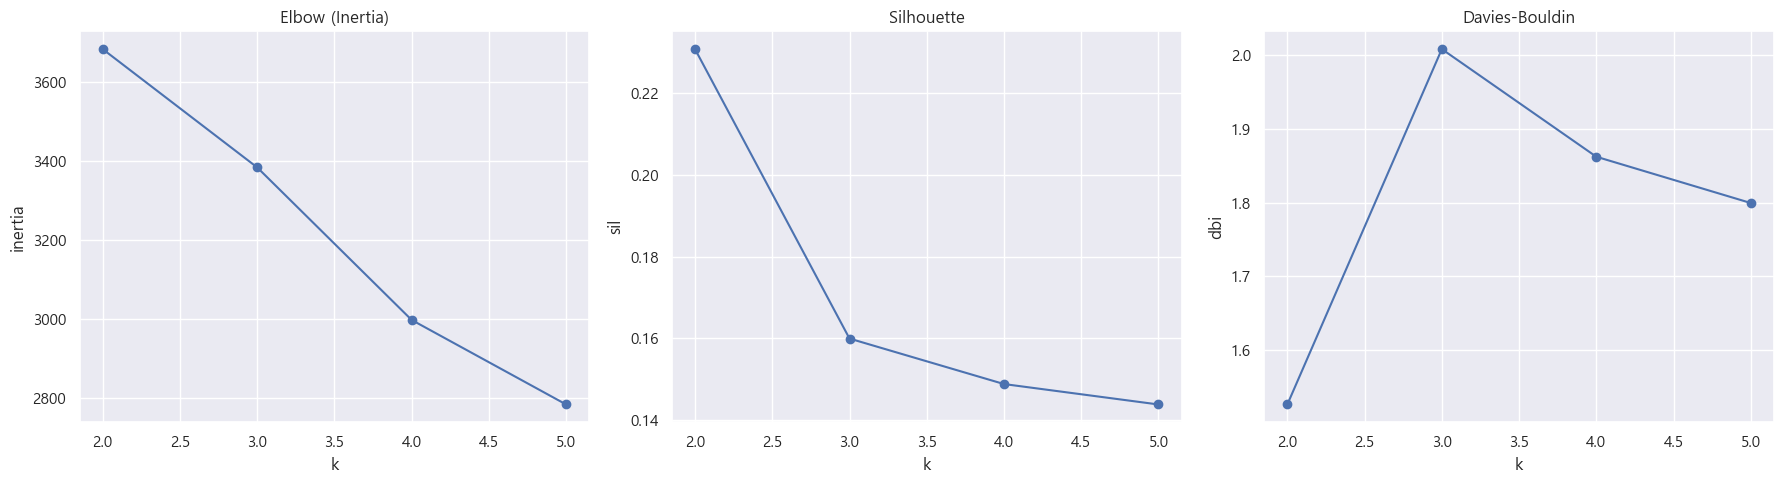

In [14]:
# 3) 표본 5만명 추출 및 KMeans 평가
from sklearn.metrics import pairwise_distances_argmin_min

N_SAMPLE = min(50000, user_dept_ratio.shape[0])
sample_user_ids = np.random.choice(user_dept_ratio.index.values, size=N_SAMPLE, replace=False)
X_sample = user_dept_ratio.loc[sample_user_ids].values.astype(np.float32)

# 스케일링은 생략 (합=1 제약하 고차원 확률분포이므로 거리 왜곡 방지 목적)

k_grid = [2, 3, 4, 5]
results = []
for k in k_grid:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=SEED, batch_size=2048, n_init='auto')
    labels = kmeans.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels)
    inertia = kmeans.inertia_
    dbi = davies_bouldin_score(X_sample, labels)
    ch = calinski_harabasz_score(X_sample, labels)
    results.append({'k': k, 'sil': sil, 'inertia': inertia, 'dbi': dbi, 'ch': ch})

res_df = pd.DataFrame(results)
print(res_df)

fig, axes = plt.subplots(1, 3, figsize=(18,5))
axes[0].plot(res_df['k'], res_df['inertia'], marker='o'); axes[0].set_title('Elbow (Inertia)'); axes[0].set_xlabel('k'); axes[0].set_ylabel('inertia')
axes[1].plot(res_df['k'], res_df['sil'], marker='o'); axes[1].set_title('Silhouette'); axes[1].set_xlabel('k'); axes[1].set_ylabel('sil')
axes[2].plot(res_df['k'], res_df['dbi'], marker='o'); axes[2].set_title('Davies-Bouldin'); axes[2].set_xlabel('k'); axes[2].set_ylabel('dbi')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'kmeans_metrics.png'))
plt.show()


In [16]:
# 4) 최적 k 선택 로직 및 전체 학습/할당
# 규칙: 실루엣 최대이면서, inertia 급감 구간 이후의 가장 작은 k 우선
best_k = int(res_df.sort_values(['sil','ch'], ascending=[False, False]).iloc[0]['k'])
print(f"선택된 k = {best_k}")

kmeans_full = MiniBatchKMeans(n_clusters=best_k, random_state=SEED, batch_size=4096, n_init='auto')
full_labels = kmeans_full.fit_predict(user_dept_ratio.values.astype(np.float32))

cluster_assign = pd.DataFrame({
    'user_id': user_dept_ratio.index.values,
    'kmeans_cluster': full_labels.astype(np.int16)
})

# 클러스터별 상위 부서 비율 요약
topn = 3
cluster_profiles = (
    user_dept_ratio.assign(kmeans_cluster=full_labels)
    .groupby('kmeans_cluster')
    .mean()
)

# department_id → name 매핑
id_to_name = departments.set_index('department_id')['department'].to_dict()
cluster_profiles.rename(columns=id_to_name, inplace=True)

def top_departments(row, n=topn):
    s = row.sort_values(ascending=False)[:n]
    return ", ".join([f"{idx}({val:.2f})" for idx, val in s.items()])

cluster_summary = pd.DataFrame({
    'cluster': cluster_profiles.index,
    'top_departments': [top_departments(cluster_profiles.loc[c]) for c in cluster_profiles.index]
})
print(cluster_summary)

cluster_assign.head()


선택된 k = 2
   cluster                                   top_departments
0        0  dairy eggs(0.16), produce(0.14), beverages(0.13)
1        1     produce(0.44), dairy eggs(0.15), snacks(0.06)


,user_id,kmeans_cluster
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


## 2. 고객 클러스터별 평균 비율 (전체 표본을 활용)

In [15]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 실행 토글
USE_SAMPLE = False   # 전체(약 20만명) 사용 시 False
SAMPLE_SIZE = 10000  # USE_SAMPLE=True일 때만 사용
RANDOM_STATE = 42

# 결측(미구매) 제외 토글 (Wide 기준에서 0 또는 EPS이하를 NaN 처리)
EXCLUDE_NONBUYERS = False
EPS = 1e-6

# 경로
PATH_ORDERS = 'orders.csv'
PATH_ORDER_PRODUCTS = 'order_products__prior.csv'
PATH_PRODUCTS = 'products.csv'
PATH_DEPARTMENTS = 'departments.csv'
PATH_USER_CLUSTER = 'user_kpi_with_cluster.csv'

FIG_DIR = 'figs'
os.makedirs(FIG_DIR, exist_ok=True)

# 한글 폰트 (Windows)
try:
    import matplotlib as mpl
    mpl.rcParams['font.family'] = 'Malgun Gothic'
    mpl.rcParams['axes.unicode_minus'] = False
except Exception:
    pass

In [3]:
# 1) 데이터 로드 및 조인
# 클러스터(공식) 유저 로드 및 샘플링
user_cluster = pd.read_csv(PATH_USER_CLUSTER, usecols=['user_id','official_cluster','total_orders','avg_basket_size','repeat_rate','avg_days_between_orders'])
user_cluster = user_cluster.dropna(subset=['official_cluster'])
user_cluster['official_cluster'] = user_cluster['official_cluster'].astype(int)

if USE_SAMPLE:
    sampled = user_cluster[['user_id']].drop_duplicates().sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE)
    user_cluster = user_cluster.merge(sampled, on='user_id', how='inner')

orders = pd.read_csv(PATH_ORDERS, usecols=['order_id','user_id'])
order_products = pd.read_csv(PATH_ORDER_PRODUCTS, usecols=['order_id','product_id'])
products = pd.read_csv(PATH_PRODUCTS, usecols=['product_id','department_id'])
departments = pd.read_csv(PATH_DEPARTMENTS, usecols=['department_id','department'])

orders = orders.merge(user_cluster[['user_id']].drop_duplicates(), on='user_id', how='inner')

op = order_products.merge(orders, on='order_id', how='inner')
op = op.merge(products, on='product_id', how='left')
op = op.merge(departments, on='department_id', how='left')
op = op[['user_id','department']].dropna()

op.head()


,user_id,department
0,202279,dairy eggs
1,202279,produce
2,202279,pantry
3,202279,pantry
4,202279,pantry


In [4]:
# 2) 유저-부서 비율 계산 (Long) → Wide 변환 및 결측 제외 토글 적용
user_total = op.groupby('user_id').size().rename('user_total')
user_dept = op.groupby(['user_id','department']).size().rename('user_dept_cnt')

user_dept_share = (
    user_dept.reset_index()
    .merge(user_total.reset_index(), on='user_id', how='left')
)
user_dept_share['share'] = user_dept_share['user_dept_cnt'] / user_dept_share['user_total']

# Wide 변환 (0 채움)
user_dept_ratio = (
    user_dept_share.pivot(index='user_id', columns='department', values='share')
    .fillna(0.0)
)

# 결측(미구매) 제외 옵션: 0 또는 EPS이하를 NaN으로 처리
udr_masked = user_dept_ratio.mask(user_dept_ratio <= EPS) if EXCLUDE_NONBUYERS else user_dept_ratio

user_dept_ratio.shape, udr_masked.shape


((206209, 21), (206209, 21))

In [5]:
# 3) user_kpi 생성 및 공식 클러스터 시리즈 준비
a = ['user_id','total_orders','avg_basket_size','repeat_rate','avg_days_between_orders','official_cluster']
user_kpi = user_cluster[a].copy()

official_series = user_kpi.set_index('user_id').reindex(udr_masked.index)['official_cluster'].fillna(0).astype(int)
official_series.head()


user_id
1    0
2    0
3    0
4    0
5    0
Name: official_cluster, dtype: int64

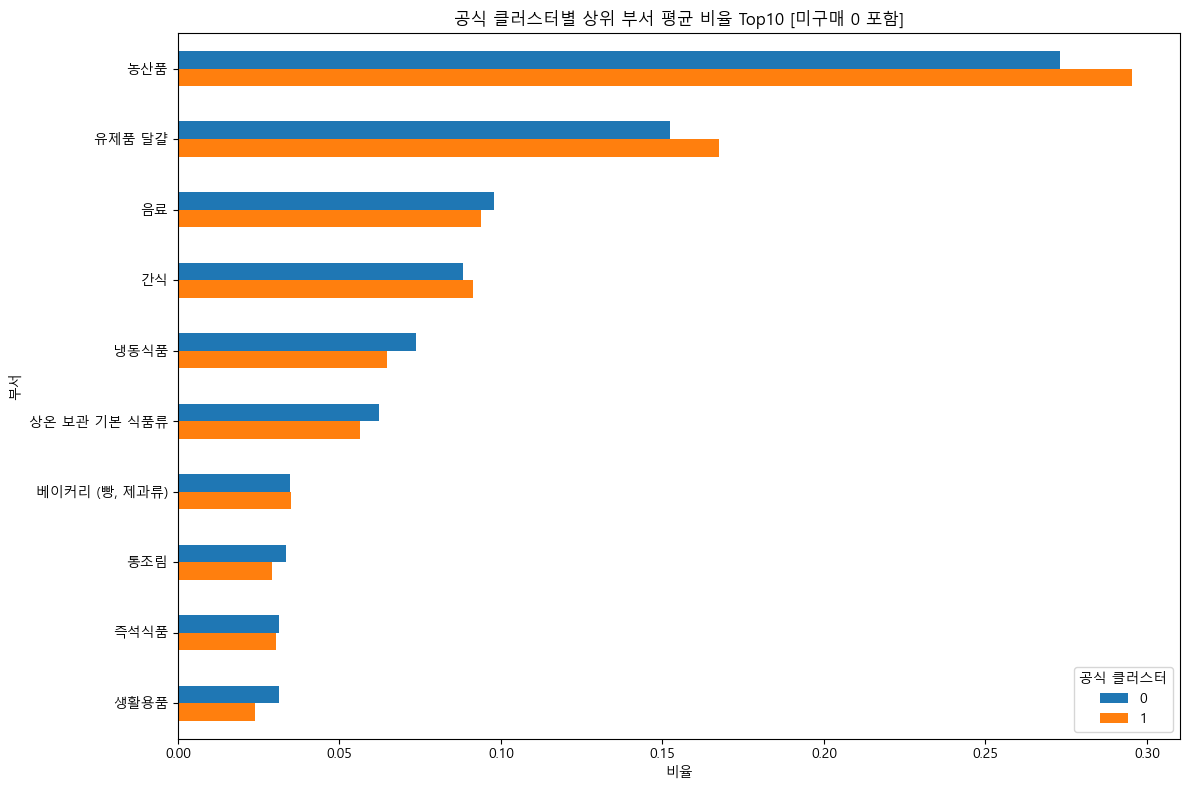

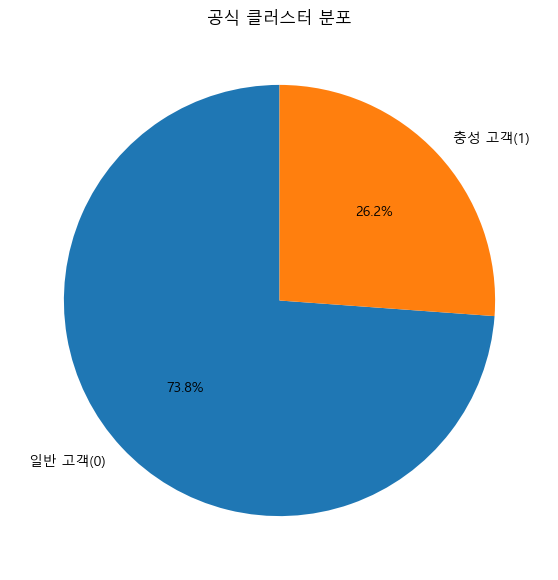

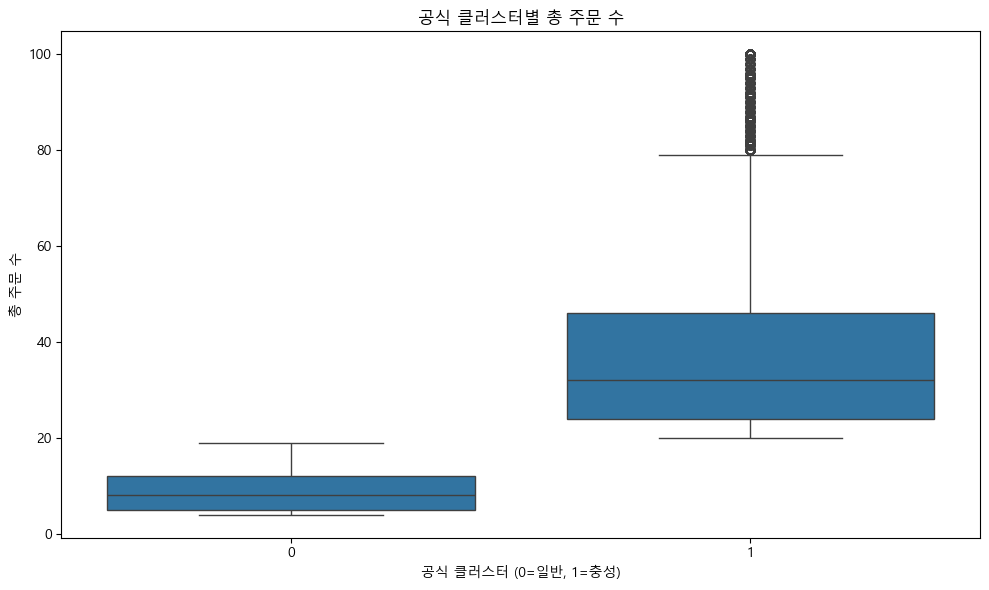

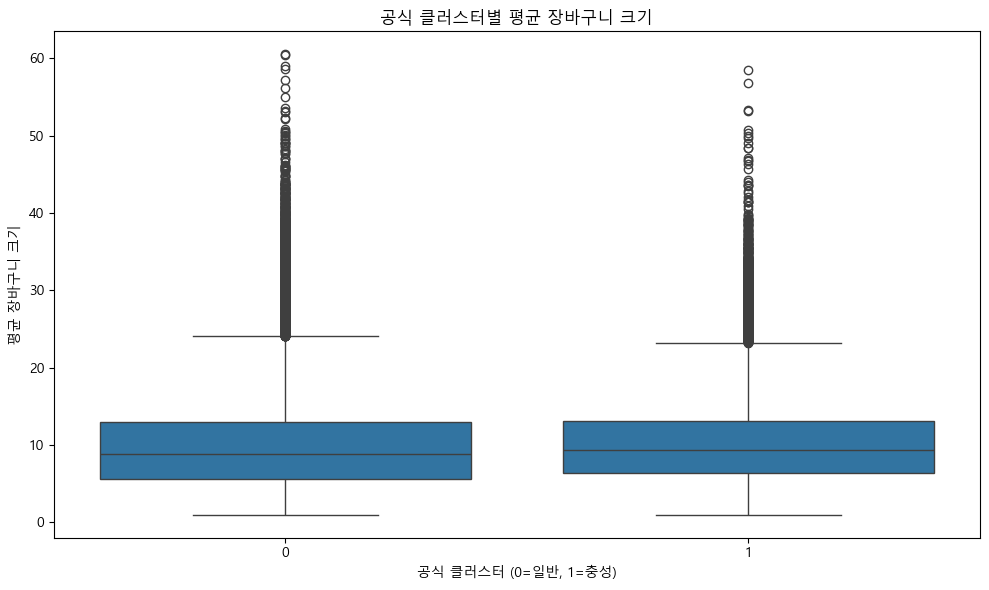

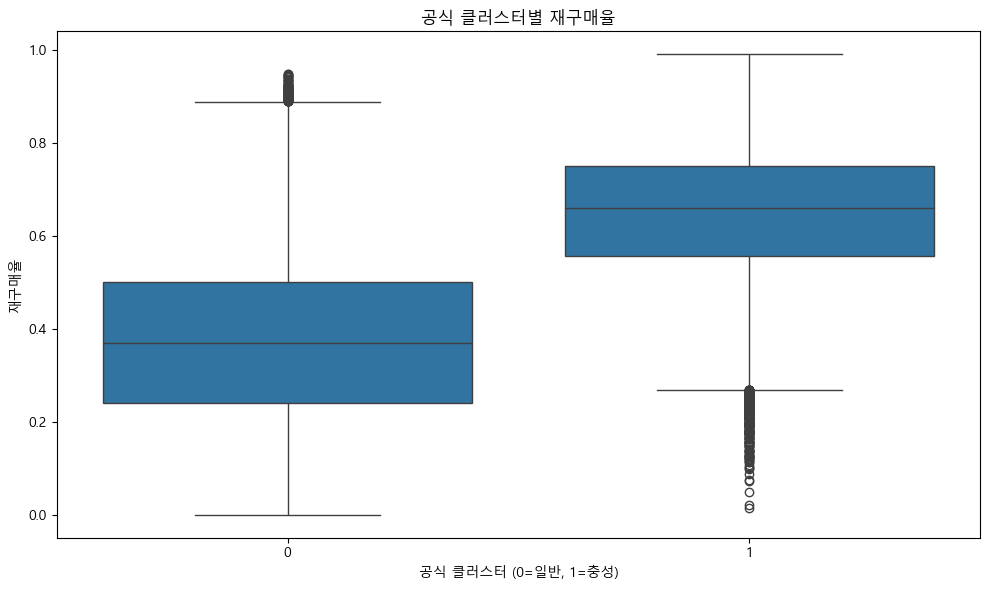

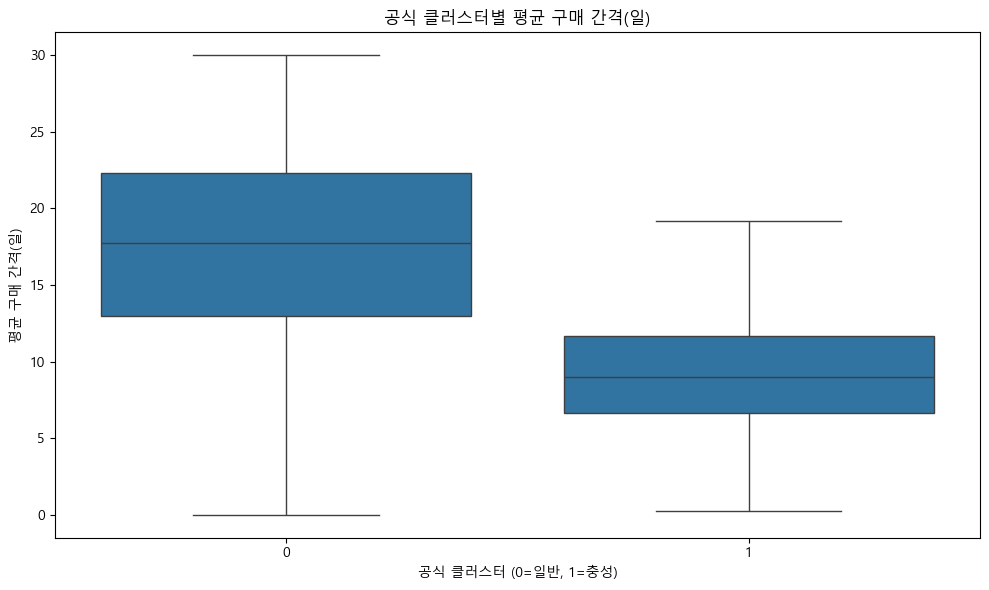

C:\Users\User\AppData\Local\Temp\ipykernel_37248\2642380862.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = {0: cm.get_cmap('tab10')(0), 1: cm.get_cmap('tab10')(1)}


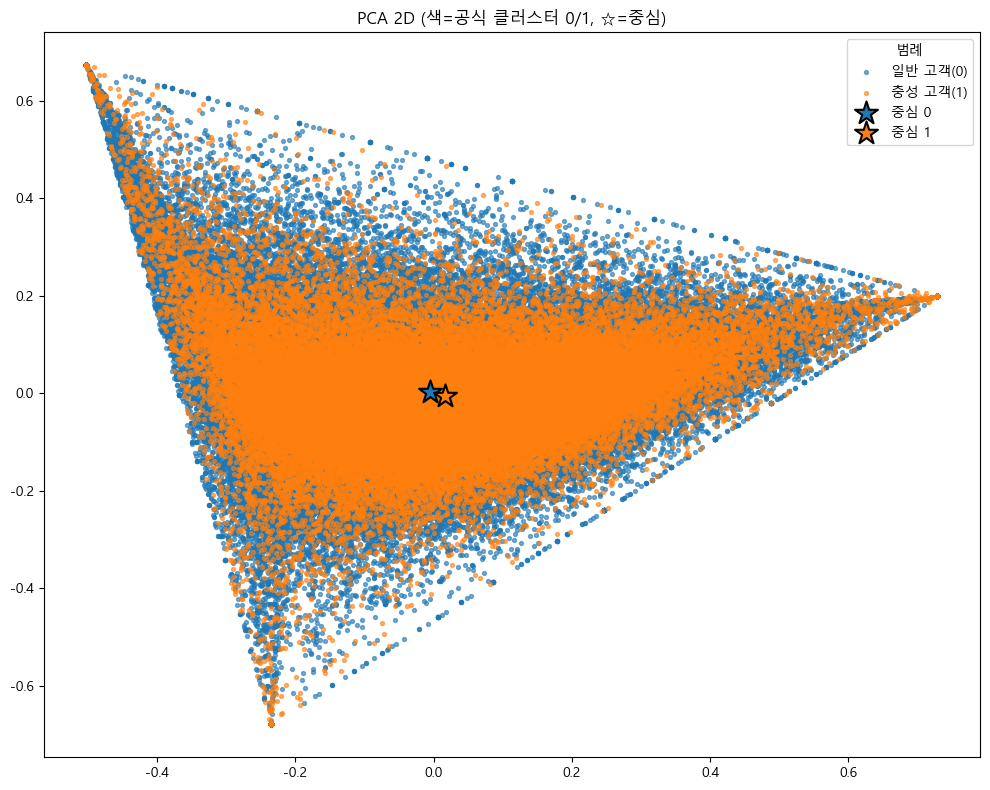

In [6]:
# 4) 한글 매핑과 시각화 4종 복구
# 부서 영→한 매핑
dept_en_to_kr = {
    'frozen': '냉동식품',
    'other': '기타',
    'bakery': '베이커리 (빵, 제과류)',
    'produce': '농산품',
    'alcohol': '주류',
    'international': '해외 식료퓸',
    'beverages': '음료',
    'pets': '애완용품',
    'dry goods pasta': '건식 파스타류',
    'bulk': '대량 구매 상품군',
    'personal care': '개인 위생 용품',
    'meat seafood': '육류 , 해산물',
    'pantry': '상온 보관 기본 식품류',
    'breakfast': '아침 식사용 식품',
    'canned goods': '통조림',
    'dairy eggs': '유제품 달걀',
    'household': '생활용품',
    'babies': '유아용품',
    'snacks': '간식',
    'deli': '즉석식품',
    'missing': '누락/분류없음',
}

korean_map = {
    'total_orders': '총 주문 수',
    'avg_basket_size': '평균 장바구니 크기',
    'repeat_rate': '재구매율',
    'avg_days_between_orders': '평균 구매 간격(일)',
}

# (1) 공식 클러스터별 상위 부서 평균 비율 바차트 (결측 제외 토글 반영)
mean_profiles = (
    udr_masked.assign(official_cluster=official_series.values)
    .groupby('official_cluster').mean()
)

id_to_name_kr = {c: dept_en_to_kr.get(c, c) for c in mean_profiles.columns}
mean_profiles_kr = mean_profiles.rename(columns=id_to_name_kr)

TOP_K = 10
mean_profiles_top10 = mean_profiles_kr[mean_profiles_kr.mean().sort_values(ascending=False).head(TOP_K).index]

ax = mean_profiles_top10.T.plot(kind='barh', figsize=(12, 8))
ax.invert_yaxis()
plt.title('공식 클러스터별 상위 부서 평균 비율 Top10' + (' [결측 제외]' if EXCLUDE_NONBUYERS else ' [미구매 0 포함]'))
plt.xlabel('비율'); plt.ylabel('부서')
plt.legend(title='공식 클러스터', loc='best')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'official_cluster_top_departments_h.png'), dpi=200, bbox_inches='tight')
plt.show()

# (2) 공식 클러스터 크기 파이차트
official_series = official_series.astype(int)
sizes = official_series.value_counts().sort_index()
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=['일반 고객(0)','충성 고객(1)'], autopct='%1.1f%%', startangle=90)
plt.title('공식 클러스터 분포')
plt.savefig(os.path.join(FIG_DIR, 'official_cluster_sizes.png'))
plt.show()

# (3) KPI 박스플롯
for col, col_kr in korean_map.items():
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(data=user_kpi, x='official_cluster', y=col)
    ax.set_xlabel('공식 클러스터 (0=일반, 1=충성)')
    ax.set_ylabel(col_kr)
    ax.set_title(f'공식 클러스터별 {col_kr}')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f'official_kpi_box_{col}.png'), dpi=200, bbox_inches='tight')
    plt.show()

# (4) PCA 2D 시각화
from matplotlib import cm
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X2 = pca.fit_transform(udr_masked.values.astype(np.float32))
palette = {0: cm.get_cmap('tab10')(0), 1: cm.get_cmap('tab10')(1)}
plt.figure(figsize=(10,8))
for c in [0,1]:
    mask = (official_series.values == c)
    label = '일반 고객(0)' if c==0 else '충성 고객(1)'
    plt.scatter(X2[mask, 0], X2[mask, 1], s=8, color=palette[c], alpha=0.6, label=label)
for c in [0,1]:
    m = X2[official_series.values == c].mean(axis=0)
    plt.scatter(m[0], m[1], marker='*', s=300, color=palette[c], edgecolor='black', linewidth=1.5, label=f'중심 {c}')
plt.title('PCA 2D (색=공식 클러스터 0/1, ☆=중심)')
plt.legend(title='범례', loc='best', frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'official_pca_scatter.png'), dpi=200, bbox_inches='tight')
plt.show()


In [7]:
# 5) 막대그래프와 동일 정의의 프린트 복구
mean_profiles_en = (
    udr_masked.assign(official_cluster=official_series.values)
    .groupby('official_cluster').mean()
)
TOP_K = 10
selected_cols = mean_profiles_en.mean().sort_values(ascending=False).head(TOP_K).index
id_to_name_kr = {c: dept_en_to_kr.get(c, c) for c in selected_cols}

for c, row in mean_profiles_en[selected_cols].iterrows():
    print(f"\n[Official Cluster {int(c)}] 상위 {TOP_K} 부서 평균 비율" + (' (결측 제외)' if EXCLUDE_NONBUYERS else ' (미구매 0 포함)'))
    for col in selected_cols:
        print(f" - {id_to_name_kr[col]}: {row[col]:.3f}")



[Official Cluster 0] 상위 10 부서 평균 비율 (미구매 0 포함)
 - 농산품: 0.273
 - 유제품 달걀: 0.152
 - 음료: 0.098
 - 간식: 0.088
 - 냉동식품: 0.074
 - 상온 보관 기본 식품류: 0.062
 - 베이커리 (빵, 제과류): 0.035
 - 통조림: 0.033
 - 즉석식품: 0.031
 - 생활용품: 0.031

[Official Cluster 1] 상위 10 부서 평균 비율 (미구매 0 포함)
 - 농산품: 0.295
 - 유제품 달걀: 0.167
 - 음료: 0.094
 - 간식: 0.091
 - 냉동식품: 0.065
 - 상온 보관 기본 식품류: 0.056
 - 베이커리 (빵, 제과류): 0.035
 - 통조림: 0.029
 - 즉석식품: 0.030
 - 생활용품: 0.024
